In [227]:
import os
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import transforms, utils

In [228]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

        

In [229]:
class OperatorsDataset(Dataset):
    """ Custom Dataset for Operators"""
    
    def __init__(self, root_dir, csv_file, transform = None, grayscale = True):
        
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.grayscale = grayscale
        
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx].path)
        image = io.imread(img_name)

        label = self.dataframe.loc[idx].label
        
        if self.transform:
            sample = self.transform(image)
        
        if self.grayscale:
            image = rgb2gray(image)
        
        image = image.astype(np.float32)
        return (image, label)

dataset = OperatorsDataset("./data/operators", "./data/operators/datasheet.csv", transform = transforms.Compose([ToTensor()]))

In [230]:
batch_size = 4
valid_size = 0.2
shuffle = True
random_seed = 1
num_workers = 0
pin_memory = 1

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers,
)
valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers,
)


In [231]:
class OperatorNet(nn.Module):
    def __init__(self):
        """ Init """
        super().__init__()
        self.fc1 = nn.Linear(32*32, 100)
        self.fc2 = nn.Linear(100, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def predict(self, x):
        x = self.forward(x)
        return F.softmax(x)


In [232]:
def validate_on_dataloader(net, dataloader):
    """
    Returns accuracy on a given dataloader
    """
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():    
        for images, labels in dataloader:

            images.resize_(images.size()[0], 1024)

            output = net(images)
            predicted = (F.softmax(output).data).max(1)[1]
            correct += (labels == predicted).sum().item()
            total += labels.size(0)

    return 100*(correct/total)

In [233]:
net = OperatorNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00005)

epochs = 100
eval_every = 10

for e in range(epochs): 
    running_loss = 0
    
    for images, labels in iter(train_loader):
        
        images.resize_(images.size()[0], 1024)
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if e % eval_every == 0:
        print("\n----------------------------------------")
        print("\nStarted on epoch {}".format(e))
        print("Loss on current epoch: {}".format(running_loss))
        
        accuracy_train = validate_on_dataloader(net, train_loader)
        print("Accuracy on train set {}".format(np.around(accuracy_train, 2)))
        
        accuracy_val = validate_on_dataloader(net, valid_loader)
        print("Accuracy on validation set {}".format(np.around(accuracy_val, 2)))
        print("----------------------------------------\n")
                
        


----------------------------------------

Started on epoch 0
Loss on current epoch: 390.3877424001694


/Users/theo/anaconda3/envs/iapr/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy on train set 71.81
Accuracy on validation set 70.99
----------------------------------------


----------------------------------------

Started on epoch 10
Loss on current epoch: 117.98741360753775
Accuracy on train set 87.22
Accuracy on validation set 86.69
----------------------------------------


----------------------------------------

Started on epoch 20
Loss on current epoch: 80.93988785240799
Accuracy on train set 91.74
Accuracy on validation set 89.08
----------------------------------------


----------------------------------------

Started on epoch 30
Loss on current epoch: 62.47345581650734
Accuracy on train set 95.23
Accuracy on validation set 92.15
----------------------------------------


----------------------------------------

Started on epoch 40
Loss on current epoch: 49.92151807527989
Accuracy on train set 96.0
Accuracy on validation set 91.47
----------------------------------------


----------------------------------------

Started on epoch 50
Loss o

Label: Equals
Predicted: Equals


/Users/theo/anaconda3/envs/iapr/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


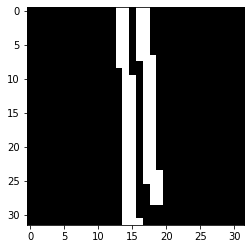

In [238]:
label_map = {0: "Plus", 1: "Minus", 2: "Multiplication", 3: "Divide", 4: "Equals"}

dataiter = iter(valid_loader)
images, labels = dataiter.next()
img_nr = np.random.randint(4, size = 1)
img, label = images[img_nr], labels[img_nr]

plt.imshow(img.resize(32,32), cmap = "Greys")
print('Label:', label_map[label.item()])

output = net(img.resize(1, 1024))
pred = (F.softmax(output).data).max(1)[1]
print('Predicted:', label_map[pred.item()])


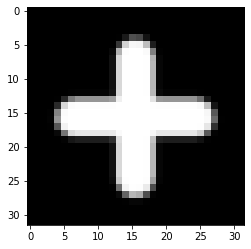

In [239]:
operators = Image.open("./data/original_operators.png")
img = np.asarray(operators)
img_grey = rgb2gray(img)
plt.imshow(img_grey, cmap = "Greys")
def extract_operators(img):
    N = 316
    plus = img[:, 0:N]
    equals = img[:, N:2*N]
    min_offset = 75
    minus = img[:, 2*N + min_offset :3*N + min_offset]
    div_offset = 125
    div = img[:, 3*N + div_offset:4*N + div_offset]
    mul_offset = 155
    mul = img[:, 4*N + mul_offset:-1]
    return [plus, minus, div, mul, equals]
operators = extract_operators(img_grey)

operators = [resize(operators[i], (32, 32)) for i in range(len(operators))]
plt.imshow(operators[0], cmap = "Greys")

In [226]:
from matplotlib import cm

i = 0
for operator in operators:
    im = Image.fromarray(np.uint8(cm.gist_earth(operator)*255))
    im.save("./data/im{}.png".format(str(i)))
    i += 1



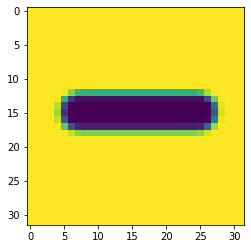

In [248]:
op_tensors = [torch.from_numpy(operators[i].astype(np.float32)) for i in range(len(operators))]
plt.imshow(op_tensors[1])

In [247]:
output = net(op_tensors[1].resize(1, 1024))
pred = (F.softmax(output).data).max(1)[1]
print('Predicted:', label_map[pred.item()])

Predicted: Minus


/Users/theo/anaconda3/envs/iapr/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
